(data_container)=
# Using shared variables (`Data` container adaptation)

:::{post} Dec 16, 2021
:tags: posterior predictive, shared data 
:category: beginner
:author: Juan Martin Loyola, Kavya Jaiswal, Oriol Abril
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from numpy.random import default_rng

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## The Data class

The {class}`pymc.Data` container class wraps the pytensor shared variable class and lets the model be aware of its inputs and outputs. This allows one to change the value of an observed variable to predict or refit on new data. All variables of this class must be declared inside a model context and specify a name for them.

In the following example, this is demonstrated with fictional temperature observations.

In [3]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-05-20")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = rng.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,14.777358,18.512741,14.971224
2020-05-02,16.325659,16.938007,15.612136
2020-05-03,14.429030,17.901775,15.835249
2020-05-04,15.668249,18.389226,16.027941
2020-05-05,16.145381,16.044643,17.492074


PyMC can also keep track of the dimensions (like dates or cities) and coordinates (such as the actual date times or city names) of multi-dimensional data. It offers two wrappers for this: `ConstantData` and `MutableData`. Both allow you specify the dimension names and coordinates of random variables, instead of specifying the shapes of those random variables as numbers. The difference is whether you intend to change this data after fitting the model, to perform out-of-sample prediciton, for example. It's most common to specify data as a `MutableData`, so we will do that here as well.

More generally, there are two ways to specify new dimensions and their coordinates:
- Entering the dimensions in the `dims` kwarg of a `pm.Data` variable with a pandas Series or DataFrame. The name of the index and columns will be remembered as the dimensions, and PyMC will infer that the values of the given columns must be the coordinates.
- Using the new `coords` argument to {class}`pymc.Model` to set the coordinates explicitly.

For more explanation about dimensions, coordinates and their big benefits, we encourage you to take a look at the {ref}`ArviZ documentation <arviz:xarray_for_arviz>`.

This is a lot of explanation -- let's see how it's done! We will use a hierarchical model: it assumes a mean temperature for the European continent and models each city relative to the continent mean:

In [4]:
# The data has two dimensions: date and city
coords = {"date": df_data.index, "city": df_data.columns}

In [5]:
with pm.Model(coords=coords) as model:
    europe_mean = pm.Normal("europe_mean_temp", mu=15.0, sigma=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic("city_temperature", europe_mean + city_offset, dims="city")

    data = pm.MutableData("data", df_data, dims=("date", "city"))
    pm.Normal("likelihood", mu=city_temperature, sigma=0.5, observed=data)

    idata = pm.sample(
        target_accept=0.85,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [europe_mean_temp, city_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/Users/jessegrabowski/mambaforge/envs/pymc-experimental/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


We can plot the digraph for our model using:

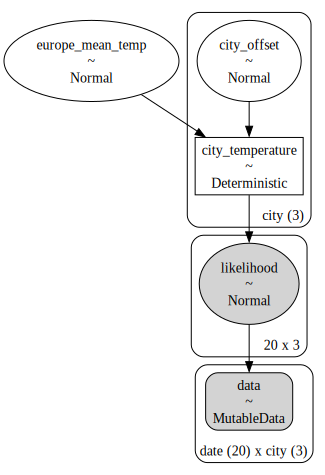

In [6]:
pm.model_to_graphviz(model)

And we see that the model did remember the coords we gave it:

In [7]:
model.coords

{'date': (Timestamp('2020-05-01 00:00:00'),
  Timestamp('2020-05-02 00:00:00'),
  Timestamp('2020-05-03 00:00:00'),
  Timestamp('2020-05-04 00:00:00'),
  Timestamp('2020-05-05 00:00:00'),
  Timestamp('2020-05-06 00:00:00'),
  Timestamp('2020-05-07 00:00:00'),
  Timestamp('2020-05-08 00:00:00'),
  Timestamp('2020-05-09 00:00:00'),
  Timestamp('2020-05-10 00:00:00'),
  Timestamp('2020-05-11 00:00:00'),
  Timestamp('2020-05-12 00:00:00'),
  Timestamp('2020-05-13 00:00:00'),
  Timestamp('2020-05-14 00:00:00'),
  Timestamp('2020-05-15 00:00:00'),
  Timestamp('2020-05-16 00:00:00'),
  Timestamp('2020-05-17 00:00:00'),
  Timestamp('2020-05-18 00:00:00'),
  Timestamp('2020-05-19 00:00:00'),
  Timestamp('2020-05-20 00:00:00')),
 'city': ('Berlin', 'San Marino', 'Paris')}

Coordinates are automatically stored into the {class}`arviz.InferenceData` object:

In [8]:
idata.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * city     (city) <U10 'Berlin' 'San Marino' 'Paris'

/Users/jessegrabowski/mambaforge/envs/pymc-experimental/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


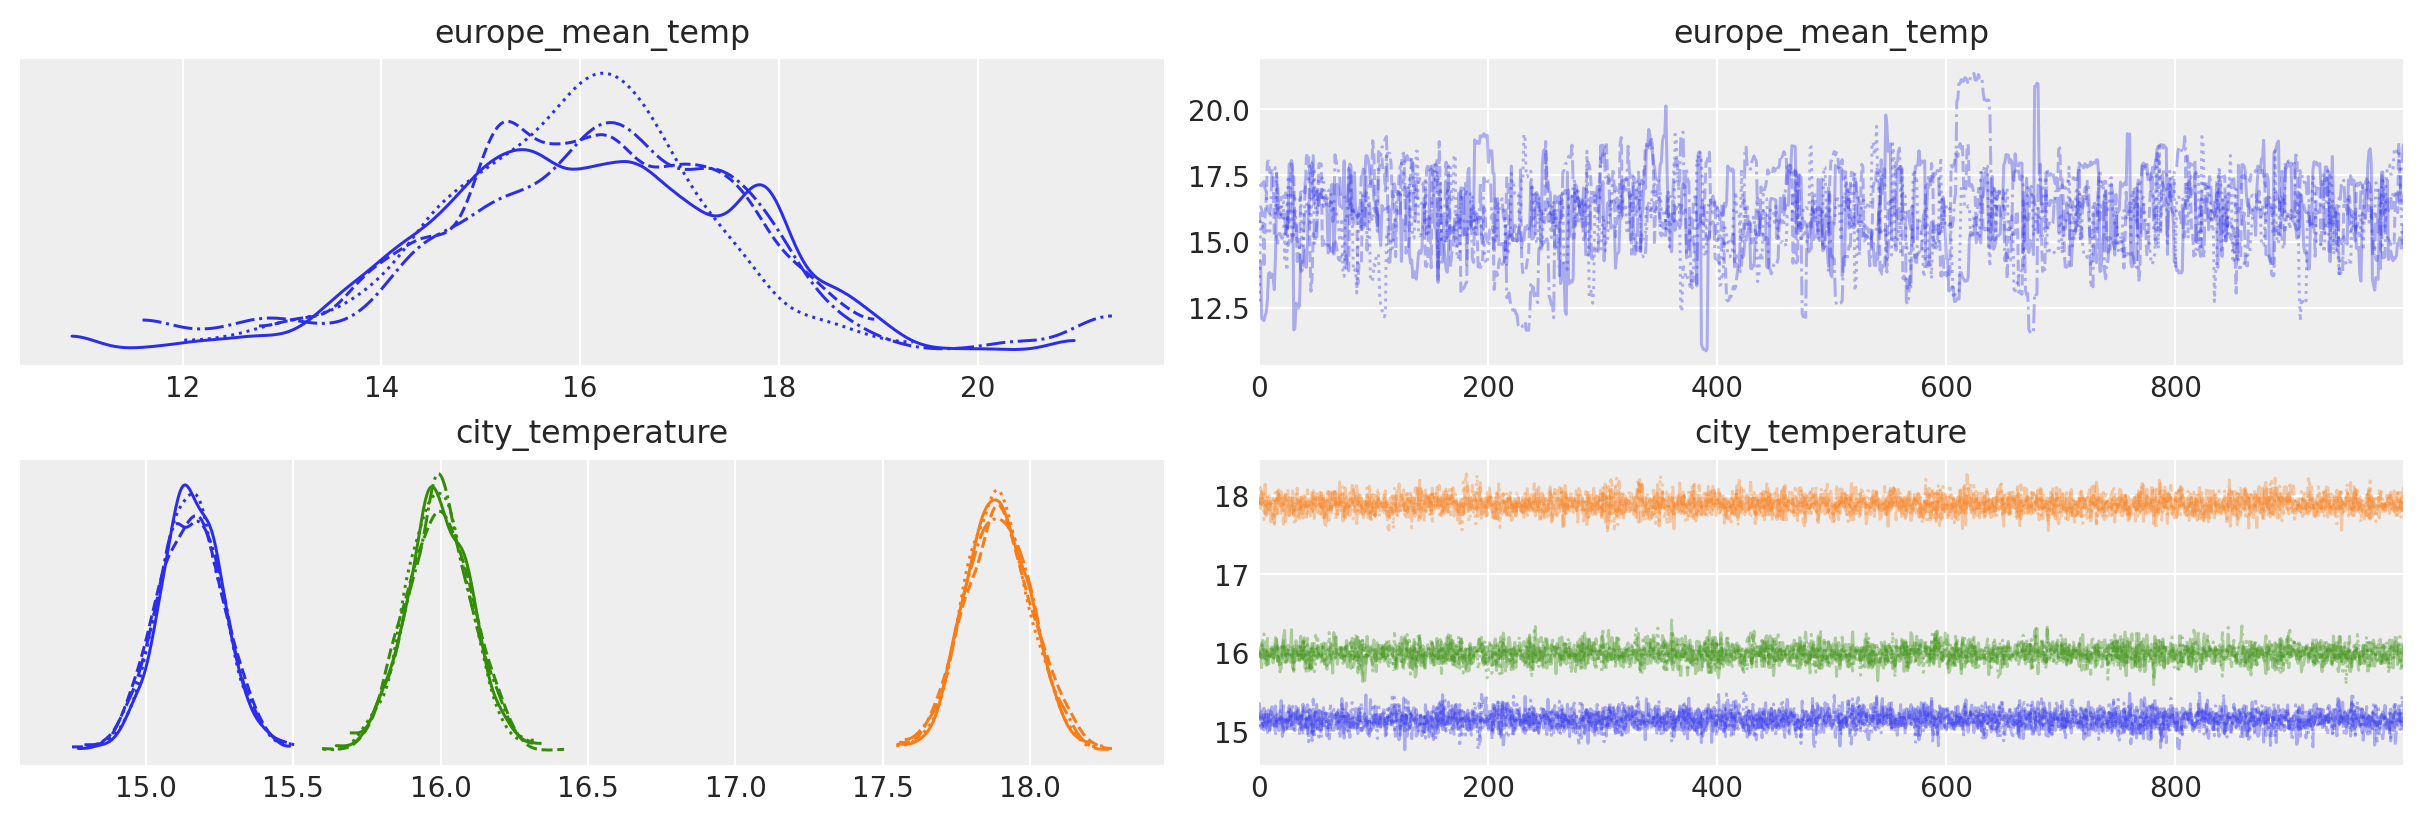

In [9]:
az.plot_trace(idata, var_names=["europe_mean_temp", "city_temperature"]);

We can get the data container variable from the model using:

In [10]:
model["data"].get_value()

array([[14.77735778, 18.51274112, 14.97122433],
       [16.32565874, 16.93800681, 15.61213579],
       [14.42902998, 17.90177483, 15.83524901],
       [15.6682492 , 18.38922566, 16.02794133],
       [16.14538102, 16.04464324, 17.49207391],
       [15.58734406, 18.33735625, 15.10719496],
       [14.94855671, 18.47742834, 15.59602844],
       [13.15495206, 16.89672523, 16.37053056],
       [14.69277964, 17.50128576, 16.18221169],
       [14.98823944, 18.9157944 , 17.35578274],
       [15.63543926, 17.36774846, 16.06602347],
       [15.11328912, 18.52343605, 14.85216414],
       [16.41879627, 18.38268978, 17.20631292],
       [15.79941587, 18.17817512, 16.29378664],
       [14.57242044, 17.24418161, 15.75391432],
       [16.53468809, 17.17038575, 16.86234979],
       [12.77264124, 18.54596355, 16.93790114],
       [15.28241532, 19.29121212, 16.04664653],
       [13.87844962, 18.49681212, 14.81167628],
       [16.30086967, 16.76326259, 14.47416939]])

Note that we used a pytensor method {meth}`pytensor.compile.sharedvalue.SharedVariable.get_value` of class {class}`pytensor.compile.sharedvalue.SharedVariable` to get the value of the variable. This is because our variable is actually a `SharedVariable`.

In [11]:
type(data)

pytensor.tensor.sharedvar.TensorSharedVariable

The methods and functions related to the Data container class are:

- `data_container.get_value` (method inherited from the pytensor SharedVariable): gets the value associated with the `data_container`.
- `data_container.set_value` (method inherited from the pytensor SharedVariable): sets the value associated with the `data_container`.
- {func}`pymc.set_data`: PyMC function that sets the value associated with each Data container variable indicated in the dictionary `new_data` with it corresponding new value.

## Using Data container variables to fit the same model to several datasets

We can use `MutableData` container variables in PyMC to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large):

In [12]:
# We generate 10 datasets
true_mu = [rng.random() for _ in range(10)]
observed_data = [mu + rng.random(20) for mu in true_mu]

with pm.Model() as model:
    data = pm.MutableData("data", observed_data[0])
    mu = pm.Normal("mu", 0, 10)
    pm.Normal("y", mu=mu, sigma=1, observed=data)

# Generate one trace for each dataset
traces = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        traces.append(pm.sample(return_inferencedata=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


## Using Data container variables to predict on new data

We can also sometimes use `MutableData` container variables to work around limitations in the current PyMC API. A common task in machine learning is to predict values for unseen data, and one way to achieve this is to use a `MutableData` container variable for our observations. When we make these predictions, the shape of the test data may not be the same as the training data. Because of this, we need to explicitly link the shapes of the input data and the output variable, via the `size` keyword.

In [13]:
x = rng.random(100)
y = x > 0

with pm.Model() as model:
    x_shared = pm.MutableData("x_shared", x)
    coeff = pm.Normal("x", mu=0, sigma=1)

    logistic = pm.math.sigmoid(coeff * x_shared)

    # Here is were we link the shapes of the inputs (x_shared) and the output
    pm.Bernoulli("obs", p=logistic, observed=y, size=x_shared.shape[0])

    # fit the model
    trace = pm.sample(return_inferencedata=True, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


In [14]:
new_values = [-1, 0, 1.0]
with model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({"x_shared": new_values})
    post_pred = pm.sample_posterior_predictive(trace)

Sampling: [obs]


The same concept applied to a more complex model can be seen in the notebook {ref}`bayesian_neural_network_advi`.

## Applied example: height of toddlers as a function of age

This example is taken from Osvaldo Martin's book: [Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC and ArviZ, 2nd Edition](https://www.amazon.com/Bayesian-Analysis-Python-Introduction-probabilistic-ebook/dp/B07HHBCR9G) {cite:p}`martin2018bayesian`.

The World Health Organization and other health institutions around the world collect data
for newborns and toddlers and design [growth charts standards](http://www.who.int/childgrowth/en/). These charts are an essential component of the paediatric toolkit and also as a measure of the general well-being of
populations in order to formulate health policies, and plan interventions and
monitor their effectiveness.

An example of such data is the lengths (heights) of newborn / toddler girls as a function of age (in months):

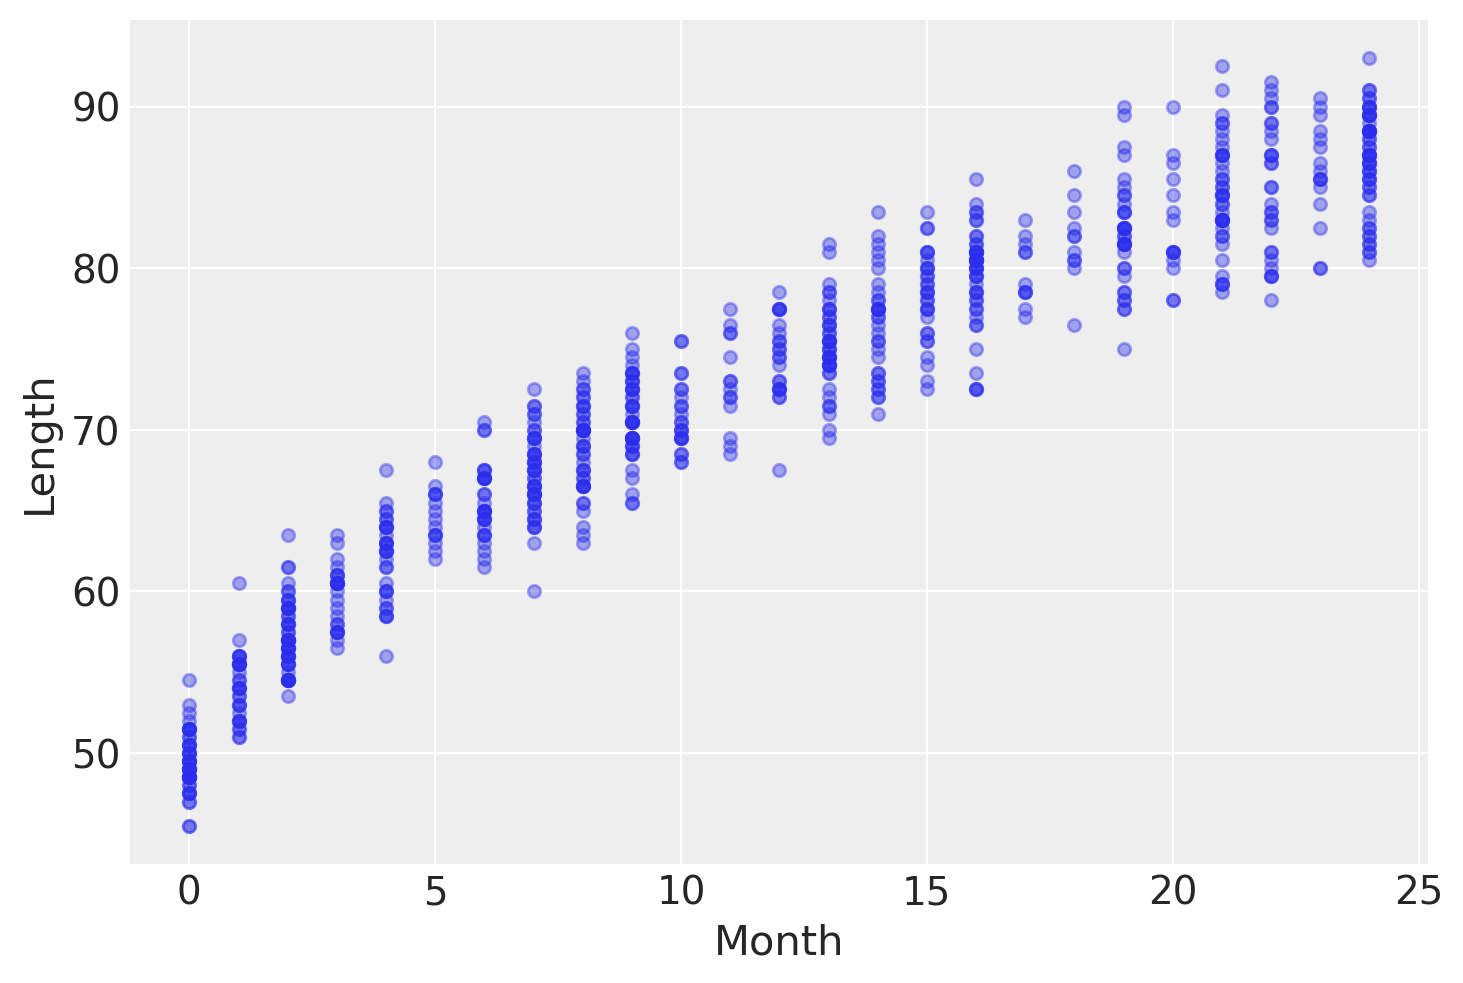

In [15]:
try:
    data = pd.read_csv("../data/babies.csv")
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("babies.csv"))
data.plot.scatter("Month", "Length", alpha=0.4);

To model this data, we will introduce one new feature: mutable `coords`. To achieve this, we set the model coords using the `pm.Model.add_cord` API, rather than via the `coords` keyword. This will allow us to pass the `mutable=True` flag to the coords, allowing them to be changed in the prediction step

In [16]:
with pm.Model() as model_babies:
    # Here is where we add mutable coords to the model
    model_babies.add_coord("time_idx", np.arange(len(data)), mutable=True)

    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    month = pm.MutableData("month", data.Month.values.astype(float), dims="time_idx")

    μ = pm.Deterministic("μ", α + β * month**0.5, dims="time_idx")
    ε = pm.Deterministic("ε", γ + δ * month, dims="time_idx")

    length = pm.Normal("length", mu=μ, sigma=ε, observed=data.Length, dims="time_idx")

    idata_babies = pm.sample(tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


The following figure shows the result of our model. The expected length, $\mu$, is represented with a blue curve, and two semi-transparent orange bands represent the 60% and 94% highest posterior density intervals of posterior predictive length measurements:

In [17]:
with model_babies:
    pm.sample_posterior_predictive(idata_babies, extend_inferencedata=True)

Sampling: [length]


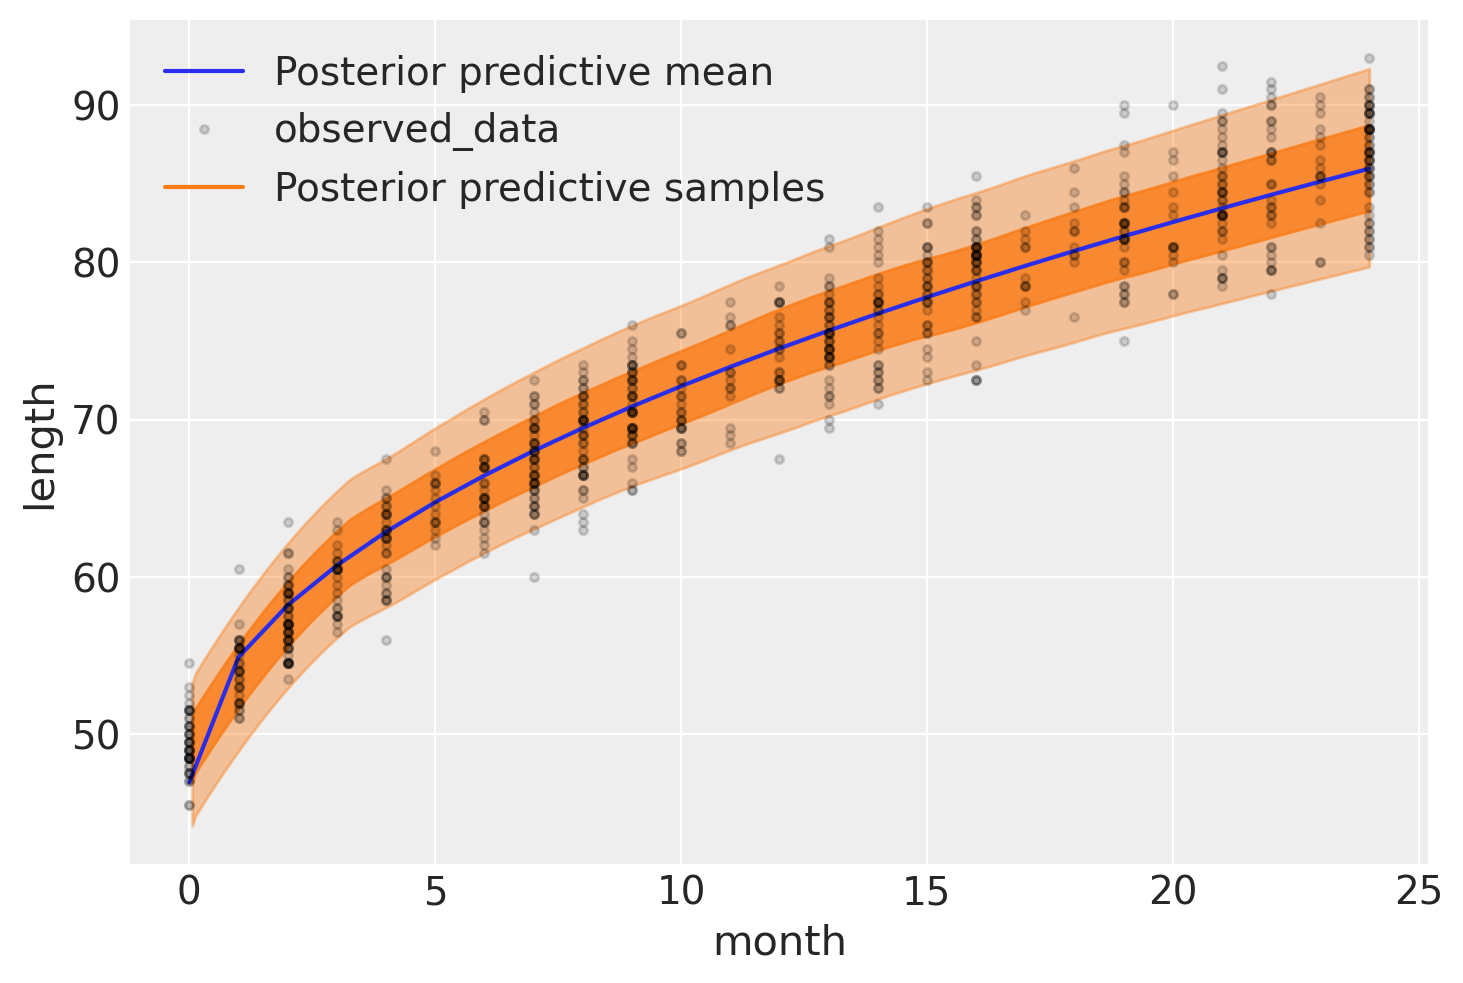

In [18]:
ax = az.plot_hdi(
    data.Month,
    idata_babies.posterior_predictive["length"],
    hdi_prob=0.6,
    fill_kwargs={"alpha": 0.8},
)
ax.plot(
    data.Month,
    idata_babies.posterior["μ"].mean(("chain", "draw")),
    label="Posterior predictive mean",
)
ax = az.plot_lm(
    idata=idata_babies,
    y="length",
    x="month",
    kind_pp="hdi",
    y_kwargs={"color": "k", "ms": 6, "alpha": 0.15},
    y_hat_fill_kwargs=dict(fill_kwargs={"alpha": 0.4}),
    axes=ax,
)

At the moment of writing Osvaldo's daughter is two weeks ($\approx 0.5$ months) old, and thus he wonders how her length compares to the growth chart we have just created. One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC we can ask this questions with the function `sample_posterior_predictive` , as this will return samples of _Length_ conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. 

The only problem is that by default this function will return predictions for _Length_ for the observed values of _Month_, and $0.5$ months (the value Osvaldo cares about) has not been observed, -- all measures are reported for integer months. The easier way to get predictions for non-observed values of _Month_ is to pass new values to the `Data` container we defined above in our model. To do that, we need to use `pm.set_data` and then we just have to sample from the posterior predictve distribution. We will also have to set `coords` for these new observations, which we are allowed to do in the `pm.set_data` function because we have set our coords as mutable.

In [19]:
ages_to_check = [0.5]
with model_babies:
    pm.set_data({"month": ages_to_check}, coords={"time_idx": [0.5]})

    # Setting predictions=True will add a new "predictions" group to our idata. This lets us store the posterior,
    # posterior_predictive, and predictions all in the same object.
    idata_babies = pm.sample_posterior_predictive(
        idata_babies, extend_inferencedata=True, predictions=True
    )

Sampling: [length]


Now we can plot the expected distribution of lengths for 2-week old babies and compute additional quantities -- for example the percentile of a child given her length. Here, let's imagine that the child we're interested in has a length of 51.5:

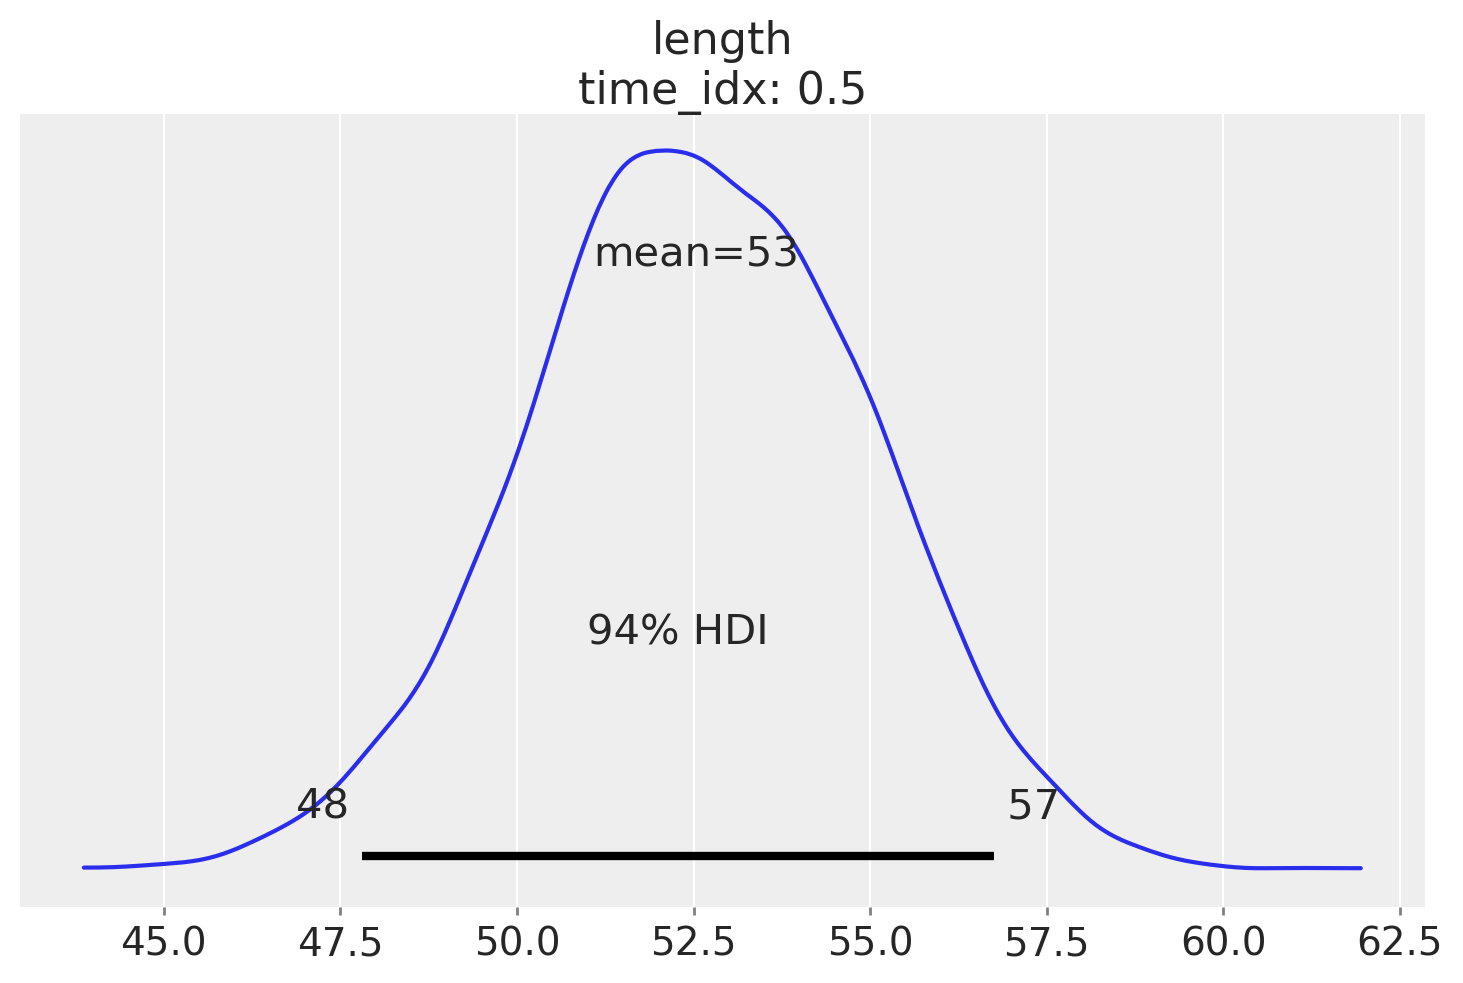

In [20]:
ref_length = 51.5

az.plot_posterior(
    idata_babies,
    group="predictions",
    ref_val={"length": [{"age (months)": 0.5, "ref_val": ref_length}]},
    labeller=az.labels.DimCoordLabeller(),
);

## Authors
* Authored by [Juan Martin Loyola](https://github.com/jmloyola) in March, 2019 ([pymc#3389](https://github.com/pymc-devs/pymc/pull/3389))
* Updated by [Kavya Jaiswal](https://github.com/KavyaJaiswal) and [Oriol Abril](https://github.com/OriolAbril) in December, 2021 ([pymc-examples#151](https://github.com/pymc-devs/pymc-examples/pull/151))
* Updated by [Jesse Grabowski](https://github.com/jessegrabowski) in July 2023 ([pymc-examples#559](https://github.com/pymc-devs/pymc-examples/pull/559))

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Wed Jul 12 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

pytensor: 2.12.3
xarray  : 2023.6.0

arviz     : 0.15.1
pymc      : 5.6.0
pandas    : 2.0.3
numpy     : 1.24.4
matplotlib: 3.7.2

Watermark: 2.4.3



:::{include} ../page_footer.md
:::